In [1]:
#导入数据
import json

file_name = r'D:\文本情感分析\wiki_word_list.json'
with open (file_name,'rb') as f:
    words_list = json.load(f)
    
file_name = r'D:\文本情感分析\wiki_words_vector.json'
with open (file_name,'rb') as f:
    words_vector = json.load(f)
    
print("数据加载完成")


数据加载完成


In [2]:
import numpy as np
words_list = np.array(words_list)
words_vector = np.array(words_vector)
print("数据格式转换完成")

数据格式转换完成


In [14]:
#语言模型太大了，截断，只取前10000个词
words_list = words_list[0:10000]
words_vector = words_vector[0:10000]
print("数据截断完成")

数据截断完成


评论的平均长度 46.89050992165877


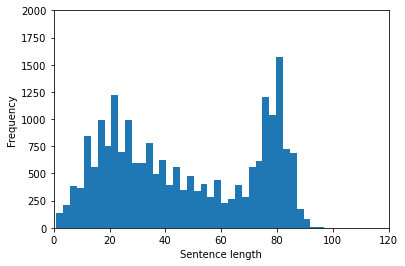

In [15]:
#分词
import numpy as np
import jieba
import matplotlib.pyplot as plt
#句子长度列表
sentence_lens = []

file_name = r'D:\文本情感分析\test_sentiment.txt'

#读取测试集样本和标签
with open(file_name,'rb') as f:
    lines = f.readlines()
    
test_sample = []    #测试集样本
test_label = []     #测试集标签

for line in lines:
    line = line.split()
    test_str = line[1].decode()        #decode表示将数据解码，从bytes转换成utf-8格式
    test_str = jieba.lcut(test_str,cut_all = False)   #对评论进行分词，以列表的形式进行保存
    test_sample.append(test_str)    
    test_label.append(line[2].decode())
    sentence_lens.append(len(test_str))
    
#读取训练集样本和标签  

file_name = r'D:\文本情感分析\train_sentiment.txt'
 
with open(file_name,'rb') as f:
    lines = f.readlines()
    
train_sample = []    #测试集样本
train_label = []     #测试集标签

for line in lines:
    line = line.split()
    train_str = line[1].decode()        #decode表示将数据解码，从bytes转换成utf-8格式
    train_str = jieba.lcut(train_str,cut_all = False)   #对评论进行分词，以列表的形式进行保存
    train_sample.append(train_str)
    train_label.append(line[2].decode())
    sentence_lens.append(len(train_str))
    
    
    
#输出句子的平均长度
sentence_ave_len = np.mean(np.array(sentence_lens))
print('评论的平均长度',sentence_ave_len)   #最终长度取50

plt.hist(sentence_lens,50)
plt.xlabel('Sentence length')
plt.ylabel('Frequency')
plt.axis([0,120,0,2000])
plt.show()

In [24]:
#word2ids
max_seq_len = 60

#words_list格式转换
words_list = words_list.tolist()


#训练数据的id转换
ids_train = np.zeros((len(train_sample),max_seq_len),dtype='int32')
sample_counter = 0  #下一个循环中，样本在样本集中的编号

for line in train_sample:
    index_counter = 0   #下一个循环中，单词在该单个样本中的编号
    
    for word in line:
        try:
            word_index = words_list.index(word)
            ids_train[sample_counter][index_counter] = word_index
            
        except ValueError:
            ids_train[sample_counter][index_counter] = 9999  #统一对语言模型中没有的词复制一个一样的词
            
        index_counter = index_counter + 1
        
        if index_counter >= max_seq_len:    #若一个评论中的单词书大于平均长度，则截断
            break
        
    sample_counter = sample_counter + 1


#测试数据的id转换
ids_test = np.zeros((len(test_sample),max_seq_len),dtype='int32')
sample_counter = 0  #下一个循环中，样本在样本集中的编号

for line in test_sample:
    index_counter = 0   #下一个循环中，单词在该单个样本中的编号
    
    for word in line:
        try:
            word_index = words_list.index(word)
            ids_test[sample_counter][index_counter] = word_index
            
        except ValueError:
            ids_test[sample_counter][index_counter] = 9999  #统一对语言模型中没有的词复制一个一样的词
            
        index_counter = index_counter + 1
        
        if index_counter >= max_seq_len:    #若一个评论中的单词书大于平均长度，则截断
            break
        
    sample_counter = sample_counter + 1
        
#保存数据ids_train,ids_test
file_name = r'D:\文本情感分析\ids_train.npy'
np.save(file_name,ids_train)

file_name = r'D:\文本情感分析\ids_test.npy'
np.save(file_name,ids_test)

#words_list格式转换
words_list = np.array(words_list)

In [4]:
#加载word2ids数据（上面cell的程序跑起来比较慢，可以直接加载之前训练好的数据）
ids_train = np.load(r'D:\文本情感分析\ids_train.npy')
ids_test = np.load(r'D:\文本情感分析\ids_test.npy')
print("数据加载完成")

数据加载完成


In [71]:
#重新设计batch数据读取
vector_dim = 300
#训练数据词向量整合
total_train_data = np.zeros([len(ids_train),max_seq_len,vector_dim],dtype = np.float32)
for i in range(len(ids_train)):
    sentence_word_id = ids_train[i]   #每个句子的id表示向量
    for j in range(len(sentence_word_id)):
        solo_word_vector = words_vector[sentence_word_id[j]]  #每个句子中的一个词的词向量
        total_train_data[i][j][:] = solo_word_vector




In [74]:
#训练数据特征整合
total_train_labels = np.array(train_label)

In [107]:
#测试数据
total_test_data = np.zeros([len(ids_test),max_seq_len,vector_dim],dtype = np.float32)
for i in range(len(ids_test)):
    sentence_word_id = ids_test[i]   #每个句子的id表示向量
    for j in range(len(sentence_word_id)):
        solo_word_vector = words_vector[sentence_word_id[j]]  #每个句子中的一个词的词向量
        total_test_data[i][j][:] = solo_word_vector
        
#测试数据标签
total_test_labels = np.array(test_label)

In [76]:
#重新设计batch数据读取
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((total_train_data, total_train_labels))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


'\ntf.data.Dataset.from_tensor_slices（）函数的参数是tensor。\n该函数的作用是接收tensor，对tensor的第一维度进行切分，并返回一个表示该tensor的切片数据集\n以minist训练集为例：\nx的shape为（60000,28,28），将x作为参数传递给tf.data.Dataset.from_tensor_slices（），\n将返回一个含有60000个切片的数据集，每个切片为 28*28 的图像（但数据集不知道里面有多少个切片）。\n\nrepeat:重复此数据集count次数\n\nshuffle:\n   随机混洗数据集的元素。\n\n   函数形式：shuffle(buffer_size,seed=None,reshuffle_each_iteration=None)\n\n     参数buffer_size:表示新数据集将从中采样的数据集中的元素数。\n     参数seed:(可选）表示将用于创建分布的随机种子。\n     参数reshuffle_each_iteration:(可选）一个布尔值，如果为true，则表示每次迭代时都应对数据集进行伪随机重组。（默认为True。）\n     \nbatch:\n\nbatch可以将数据集的连续元素合成批次。\n\n   函数形式：batch(batch_size,drop_remainder=False)\n\n   参数batch_size:表示要在单个批次中合并的此数据集的连续元素个数。\n   参数drop_remainder：表示在少于batch_size元素的情况下是否应删除最后一批 ; 默认是不删除。\n   \n'

In [128]:
#定义模型初始化系数（超参数设定）

# dataset parameters.
num_classes = 3 # 三分类.
#num_features = 60*300 # data features (shape: word60*vector300).
vector_dim = 300
max_seq_len = 60

# Training Parameters
learning_rate = 0.001
training_steps = 60000
batch_size = 32
display_step = 1000

num_units = 32  # number of neurons for the LSTM layer.

print("参数初始化完成")

参数初始化完成


In [129]:
#构建LSTM模型
from tensorflow.keras import Model, layers

class LSTM(Model):
    # Set layers.
    def __init__(self):
        super(LSTM, self).__init__()
        # RNN (LSTM) hidden layer.
        self.lstm_layer = layers.LSTM(units=num_units)  #,return_sequences=True)
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        # LSTM layer.
        x = self.lstm_layer(x)
        # Output layer (num_classes).
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build LSTM model.
lstm_net = LSTM()  #实例化

print("实例化完成")

实例化完成


In [130]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)   #将y的数据格式转化成dtype数据类型
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Adam optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

print('损失函数、精度和优化器定义完成')

损失函数、精度和优化器定义完成


In [131]:
# Optimization process. 训练过程
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = lstm_net(x, is_training=True)
        
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = lstm_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update weights following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
print('训练流程定义完成')

训练流程定义完成


In [ ]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):  
    #enumerate（）枚举函数，第二个参数表示枚举计数从1开始算
    #如果a是一个numpy array，a.take(m,1)表示取每一行的第m个值；a.take(m,0)表示取第m行
    batch_y_int = np.empty(len(batch_y))
    #将标签batch_y从str转换为int格式
    for i in range(len(batch_y)):
        temp_value = batch_y[i]
        batch_y_int[i] = int(float(temp_value))
    
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y_int)
    
    if step % display_step == 0:
        pred = lstm_net(batch_x, is_training=True)  #is_training用来设定是否边训练边验证
        loss = cross_entropy_loss(pred, batch_y_int)
        acc = accuracy(pred, batch_y_int)   #这里好像没有使用测试集
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

In [127]:
#模型评估
m = tf.keras.metrics.SparseCategoricalAccuracy()
num_battches = int(len(ids_test)//batch_size)

for batch_index in range(num_battches):
    start_index,end_index = batch_index*batch_size,(batch_index+1)*batch_size
    y_pred = lstm_net.predict(total_test_data[start_index:end_index])
    batch_labels = np.empty(end_index-start_index)
    for j in range(end_index-start_index):
        temp_value = total_test_labels[start_index+j]
        batch_labels[j] = int(float(temp_value))
        
    m.update_state(y_true = batch_labels,y_pred = y_pred)
    
print("test accuracy:%f"%m.result())

test accuracy:0.861298
